In [52]:
library(tidymodels)
library(tidyverse)
library(repr)
library(readxl)
library(themis)
options(repr.matrix.max.rows = 6)

# Predicting Newsletter Subscription in Minecraft Players Using Age and Gameplay Hours



In [38]:
player_data <- read_csv("players.csv")
session_data <- read_csv("sessions.csv")

player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [39]:
#this cell tidies the data and redies it to be analyzed and made into a vizualization and model

player_data_clean_0 <- select(player_data, -hashedEmail) |>
    select(-name) |>
  mutate(subscribe = as.factor(subscribe),
    gender = as.factor(gender),
    experience = as.factor(experience))

player_data_clean <- player_data_clean_0 |>
select(subscribe, played_hours, Age)|>
drop_na()

player_data_clean

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.3,22
FALSE,0.0,17
FALSE,2.3,17


Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


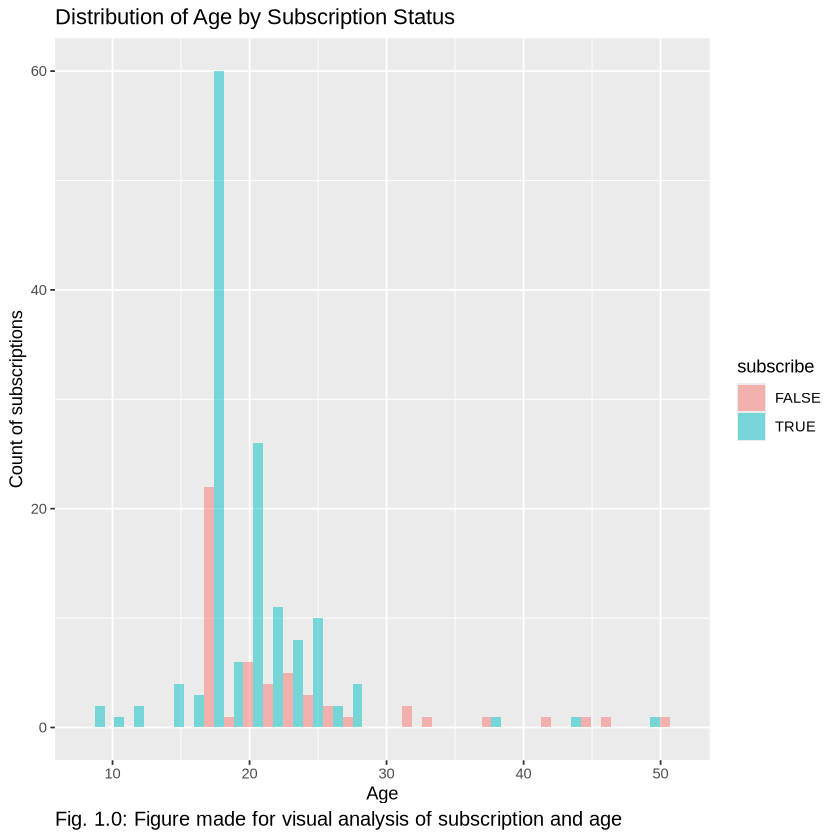

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


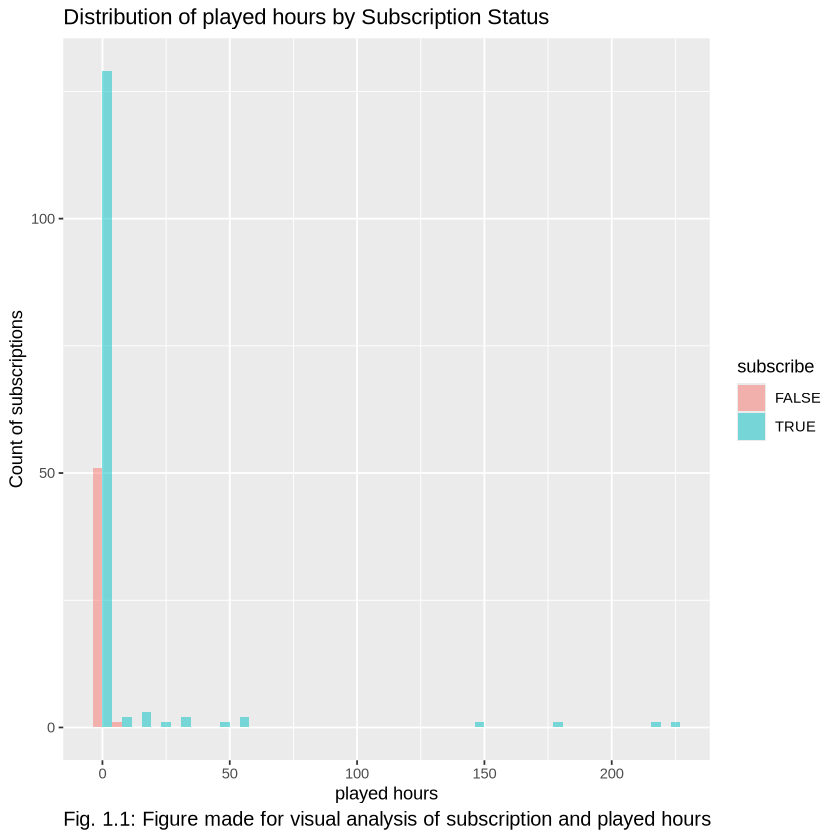

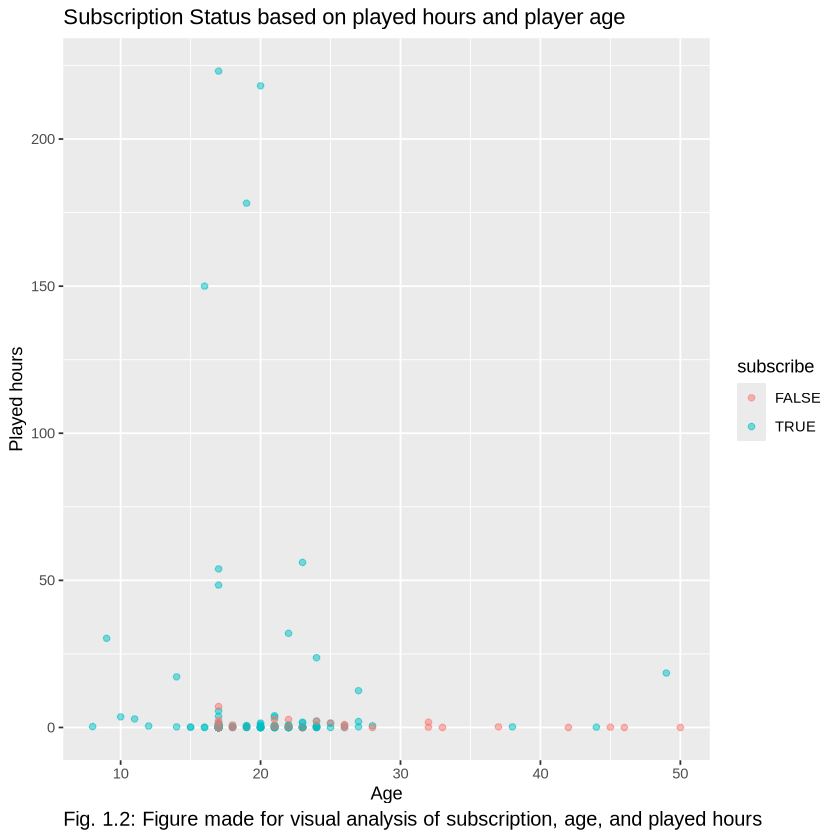

In [72]:
#this cell makes the important vizualizations showing relation ships between variables and subscription


# player_barplot <- ggplot(player_data, aes(x = gender, fill = subscribe)) +
#   geom_bar(position = "fill") +
#   labs(
#     title = "Proportion Subscribed by Gender",
#     y = "Proportion of subscription", x = "Gender")

# player_barplot_experience <- ggplot(player_data, aes(x = experience, fill = subscribe)) +
#   geom_bar(position = "fill") +
#   labs(
#     title = "Proportion Subscribed by experience",
#     y = "Proportion of subscription", x = "Experience level")

player_histogram <- ggplot(player_data, aes(x = Age, fill = subscribe)) +
  geom_histogram(position = "dodge", alpha = 0.5, bins = 30) +
  labs(title = "Distribution of Age by Subscription Status",
       x = "Age", y = "Count of subscriptions", 
       caption = "Fig. 1.0: Figure made for visual analysis of subscription and age") +
  theme(plot.caption = element_text(size = 12, hjust = 0))

player_histogram_hours <- ggplot(player_data, aes(x = played_hours, fill = subscribe)) +
  geom_histogram(position = "dodge", alpha = 0.5, bins = 30) +
  labs(title = "Distribution of played hours by Subscription Status",
       x = "played hours", y = "Count of subscriptions", 
       caption = "Fig. 1.1: Figure made for visual analysis of subscription and played hours") +
  theme(plot.caption = element_text(size = 12, hjust = 0))

player_scatter <- ggplot(player_data, aes(x = Age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.5) +
  labs(title = "Subscription Status based on played hours and player age",
       x = "Age", y = "Played hours", 
       caption = "Fig. 1.2: Figure made for visual analysis of subscription, age, and played hours") +
  theme(plot.caption = element_text(size = 12, hjust = 0))

# player_barplot
# player_barplot_experience
player_histogram
player_histogram_hours
player_scatter

In [74]:
set.seed(23)
# This cell is for the KNN classification model for the prediction of subscriptions

player_data_clean <- player_data_clean |>
  mutate(age = scale(Age),
    hours = scale(played_hours))

# Split the data into training and testing sets
data_split <- initial_split(player_data_clean, prop = 0.75, strata = subscribe)
train_data <- training(data_split)
test_data  <- testing(data_split)

# Create the folds for cross-validation
folds <- vfold_cv(train_data, v = 5, strata = subscribe)

#Create a table with k values
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

# Create a recipe
knn_recipe <- recipe(subscribe ~ age + hours, data = train_data) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

# Specify the model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

# Create a workflow and use tune grid
knn_workflow <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = folds, grid = k_vals) |>
  collect_metrics()

#find the best K to use in the model
accuracies <- knn_workflow |>
          filter(.metric == "accuracy") 
          
best_k <- accuracies |> 
          slice_max(mean, n = 1) |>
          pull(neighbors)
best_k

[1] 15

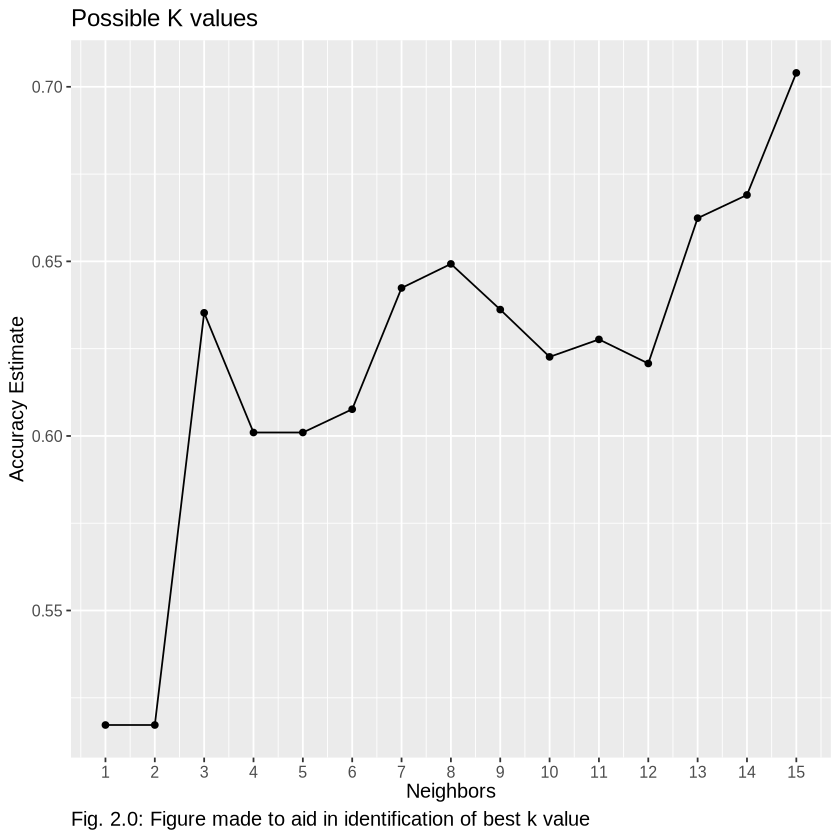

In [75]:
#this cell is for the plot of accuracy vs k to determine the best values of k

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title = "Possible K values",
       caption = "Fig. 2.0: Figure made to aid in identification of best k value") +
  theme(text = element_text(size = 12)) +
theme(plot.caption = element_text(size = 12, hjust = 0)) +
  scale_x_continuous(breaks = seq(0, 15, by = 1))
accuracy_vs_k

In [76]:
set.seed(29)
#use the best k to train the model once again
knn_spec_best <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(knn_recipe) |>
  add_model(knn_spec_best) |>
  fit(data = train_data)

#Use the new trained model to make predictions on the test set, look at its confusion matrix and assess its accuracy, precision, and recall
player_test_predictions <- predict(knn_fit, test_data) |>
  bind_cols(test_data)

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

player_test_predictions |> pull(subscribe) |> levels()

player_test_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "first")

player_test_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "first")

confusion <- player_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


[1] "FALSE" "TRUE"

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.6666667


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.1538462


          Truth
Prediction FALSE TRUE
     FALSE     2    1
     TRUE     11   35

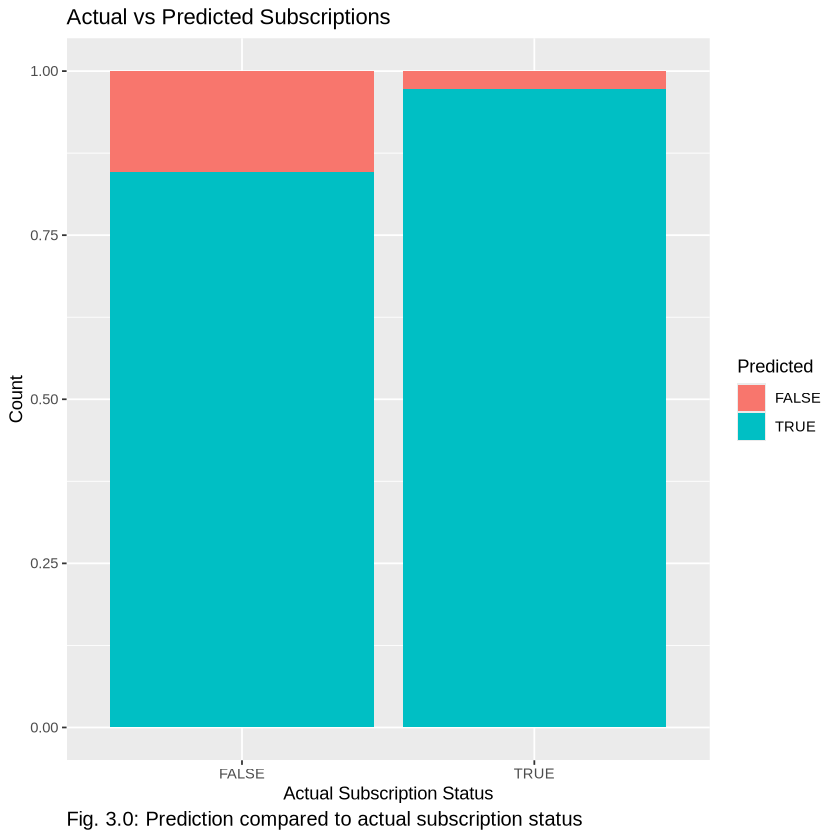

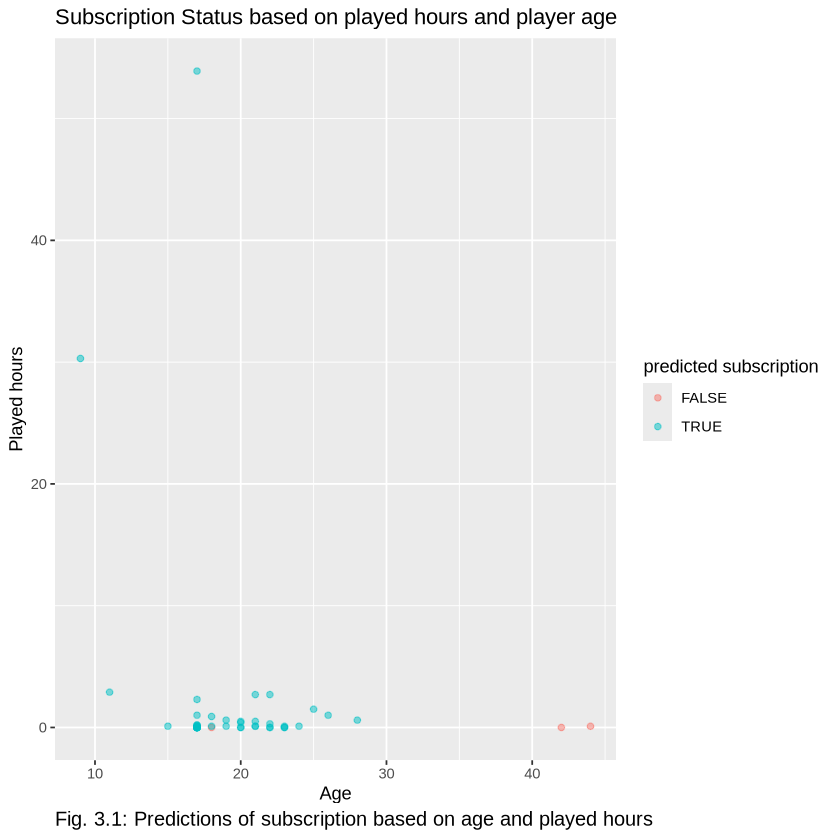

In [77]:
#Show the predictions on a plot, comparing them to the answers.

ggplot(player_test_predictions, aes(x = subscribe, fill = .pred_class)) +
  geom_bar(position = "fill") +
  labs(
    title = "Actual vs Predicted Subscriptions",
    x = "Actual Subscription Status",
    y = "Count",
    fill = "Predicted", 
    caption = "Fig. 3.0: Prediction compared to actual subscription status") +
  theme(plot.caption = element_text(size = 12, hjust = 0))

player_scatter_predictions <- ggplot(player_test_predictions, aes(x = Age, y = played_hours, color = .pred_class)) +
  geom_point(alpha = 0.5) +
  labs(title = "Subscription Status based on played hours and player age",
       x = "Age", y = "Played hours", color = "predicted subscription", 
       caption = "Fig. 3.1: Predictions of subscription based on age and played hours") +
theme(plot.caption = element_text(size = 12, hjust = 0))

player_scatter_predictions